# Empirical Bayes
This technique allows one to assess how reliable a certain rate is when dealing with too low numbers, like how different is a customer that bought online 1 out of 2 shopping events and another who bought online 2 out of 4 times.

In [ ]:
!pip install distfit --quiet

In [2]:
# Imports
import pandas as pd
import numpy as np
import scipy.stats as scs
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from distfit import distfit

In [5]:
# Load data to session
df = pd.read_csv('/content/ecomm_data.csv')
df.head()

,customer,brick_mortar,ecomm
0,1,30,0
1,2,25,0
2,3,68,0
3,4,77,0
4,5,24,0


In [ ]:
df.query('ecomm >=1').sample(5)

,customer,brick_mortar,ecomm
2274,2275,6,3
807,808,11,1
2583,2584,63,3
671,672,1,1
2045,2046,0,1


Now we are interested in seeing how different the customers that bought only a couple of times in ecomm are. Meaning, how can I say that a customer that bought 1 time in ecomm is different than the one that bought 0 times. The amount is too small to know their potential to grow.

### Let's go ahead and create a rate of visits to a phisycal store per times bought online
First, I will eliminate the customers that are byuing in only one channel.

In [6]:
# Creating success ratio
df2c = (
    df
    .query('ecomm > 0 & brick_mortar > 0')
    .assign(total_trx = df['brick_mortar'] + df['ecomm'],
            ratio = df['ecomm']/(df['brick_mortar'] + df['ecomm'])  )
)

display(df2c)

,customer,brick_mortar,ecomm,total_trx,ratio
19,20,35,2,37,0.054054
21,22,12,4,16,0.250000
43,44,12,9,21,0.428571
47,48,26,1,27,0.037037
57,58,32,9,41,0.219512
...,...,...,...,...,...
2876,2877,5,1,6,0.166667
2940,2941,8,8,16,0.500000
2943,2944,6,5,11,0.454545
2953,2954,21,1,22,0.045455


In [7]:
# Looking at the distribution
px.histogram(df2c,
             x='ratio', nbins=20,
             template="simple_white", width = 1000,
             title='Histogram of the Ratio e-Comm vs Total Transactions')

### Fitting a Beta Distribution as our prior probability
Now we can fit a distribution to act as our prior probability. For that, let's use the module dist fit.

In [8]:
# Our distribution
X = df2c['ratio']

# Initialize using the parametric approach.
#dfit = distfit(method='parametric', todf=True)

# Alternatively limit the search for only a few theoretical distributions.
dfit = distfit(method='parametric', todf=True, distr=['beta'])

# Fit model on input data X.
dfit.fit_transform(X)

# Print the bet model results.
dfit.model

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [beta] [0.13 sec] [RSS: 0.823271] [loc=0.011 scale=0.941]
[distfit] >INFO> [beta] [0.14 sec] [RSS: 0.823271] [loc=0.011 scale=0.941]
[distfit] >INFO> Compute confidence intervals [parametric]


{'name': 'beta',
 'score': 0.8232713059833795,
 'loc': 0.011363636363636362,
 'scale': 0.9411483584238516,
 'arg': (0.850939343634336, 1.4553354599535102),
 'params': (0.850939343634336,
  1.4553354599535102,
  0.011363636363636362,
  0.9411483584238516),
 'model': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7b75100d6500>,
 'bootstrap_score': 0,
 'bootstrap_pass': None,
 'color': '#e41a1c',
 'CII_min_alpha': 0.030238213140192628,
 'CII_max_alpha': 0.8158034848017729}

[distfit] >INFO> Create PDF plot for the parametric method.
[distfit] >INFO> Estimated distribution: Beta(loc:0.011364, scale:0.941148)
[distfit] >INFO> Create CDF plot for the parametric method.
[distfit] >INFO> Ploting CDF


(None,
 <Axes: title={'center': 'QQ-plot\nbeta(a=0.850939, b=1.45534, loc=0.0113636, scale=0.941148)'}, xlabel='Theoretical Quantiles', ylabel='Sample Quantiles'>)

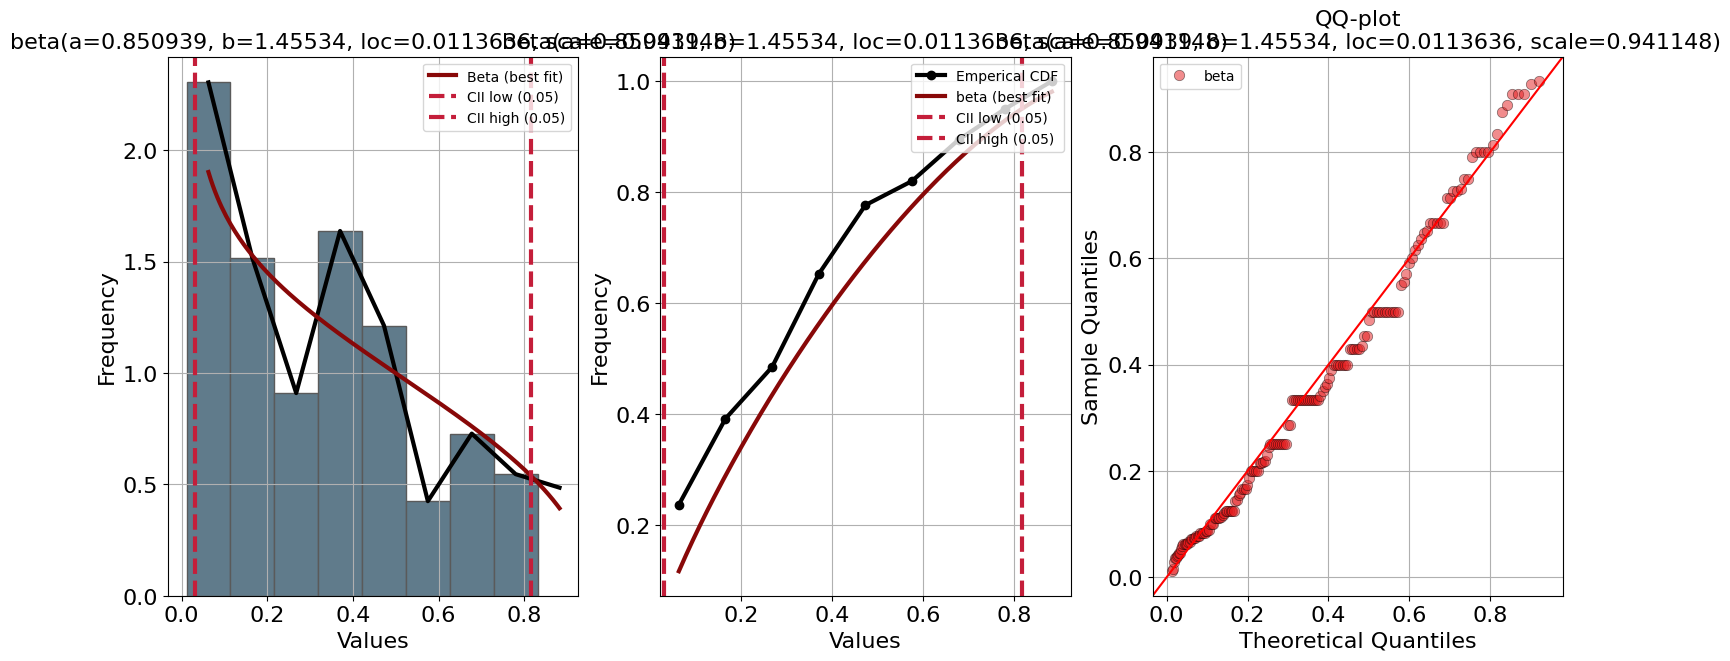

In [9]:
import matplotlib.pyplot as plt
# Create subplot
fig, ax = plt.subplots(1,3, figsize=(18, 7))
# Plot PDF with histogram
dfit.plot(chart='PDF', ax=ax[0])
# Plot the CDF
dfit.plot(chart='CDF', ax=ax[1]);
dfit.qqplot(X, ax=ax[2])

In [25]:
# Alpha and Beta values
a,b = 0.850939343634336, 1.4553354599535102

Now that we know the estimated parameters of the Beta Distribution, let's model our ratio of e-Commerce transactions with Empirical Bayes.
We'll start with our overall prior, and update based on the individual evidence. *The calculation is adding the **a** to the number e-Comm orders , and **a+b** to the total number of orders.*

In [11]:
# Calculating Bayes Estimates
df2c = (df2c
        .assign(emp_bayes = (df2c['ecomm'] + a)/(df2c['total_trx'] + a + b) )
        )


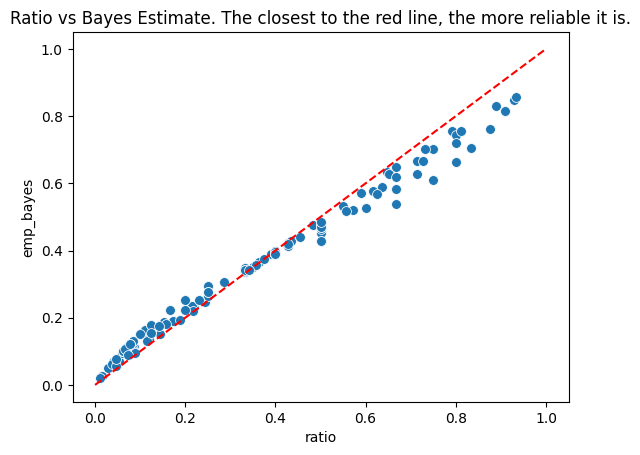

In [12]:
# Scatterplot
fig = sns.scatterplot(data = df2c,
                 x= 'ratio', y= 'emp_bayes',
                 s=50).set_title('Ratio vs Bayes Estimate. The closest to the red line, the more reliable it is.')

# Slope line
plt.plot([0,1], [0,1], linestyle='--', color='red');

In [13]:
df2c.sort_values('ecomm', ascending=False).head(30)

,customer,brick_mortar,ecomm,total_trx,ratio,emp_bayes
360,361,18,33,51,0.647059,0.635027
2359,2360,12,24,36,0.666667,0.648743
974,975,68,22,90,0.244444,0.247556
1049,1050,39,21,60,0.350000,0.350702
2002,2003,7,19,26,0.730769,0.701291
749,750,5,19,24,0.791667,0.754609
812,813,65,18,83,0.216867,0.220980
270,271,25,16,41,0.390244,0.389111
2460,2461,2,16,18,0.888889,0.829839
2724,2725,31,16,47,0.340426,0.341761


In [14]:
fig = px.scatter(df2c,
           x='ratio', y= 'emp_bayes',
           width=1000)
fig.update_layout(shapes = [{'type': 'line', 'yref': 'paper', 'xref': 'paper', 'y0': 0, 'y1': 1, 'x0': 0, 'x1': 1}])

fig.show()

## Calculating the Confidence interval

In [15]:
# Calc a1 and b1 by observation
df2 = (df2c
       .assign(a1 = df2c.ecomm + a,
                  b1 = df2c.total_trx - df2c.ecomm + b,)
)

# Calculating the CI and add to the dataset
df2 = (df2.
           assign( low = scs.beta.interval(.95, df2.a1, df2.b1)[0],
                  high = scs.beta.interval(.95, df2.a1, df2.b1)[1] )
           .sort_values('total_trx', ascending=False)
           )

In [16]:
# customer ID to string for better visualization
df2['customer'] = df2.customer.astype('string')

[distfit] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[distfit] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[distfit] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[distfit] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


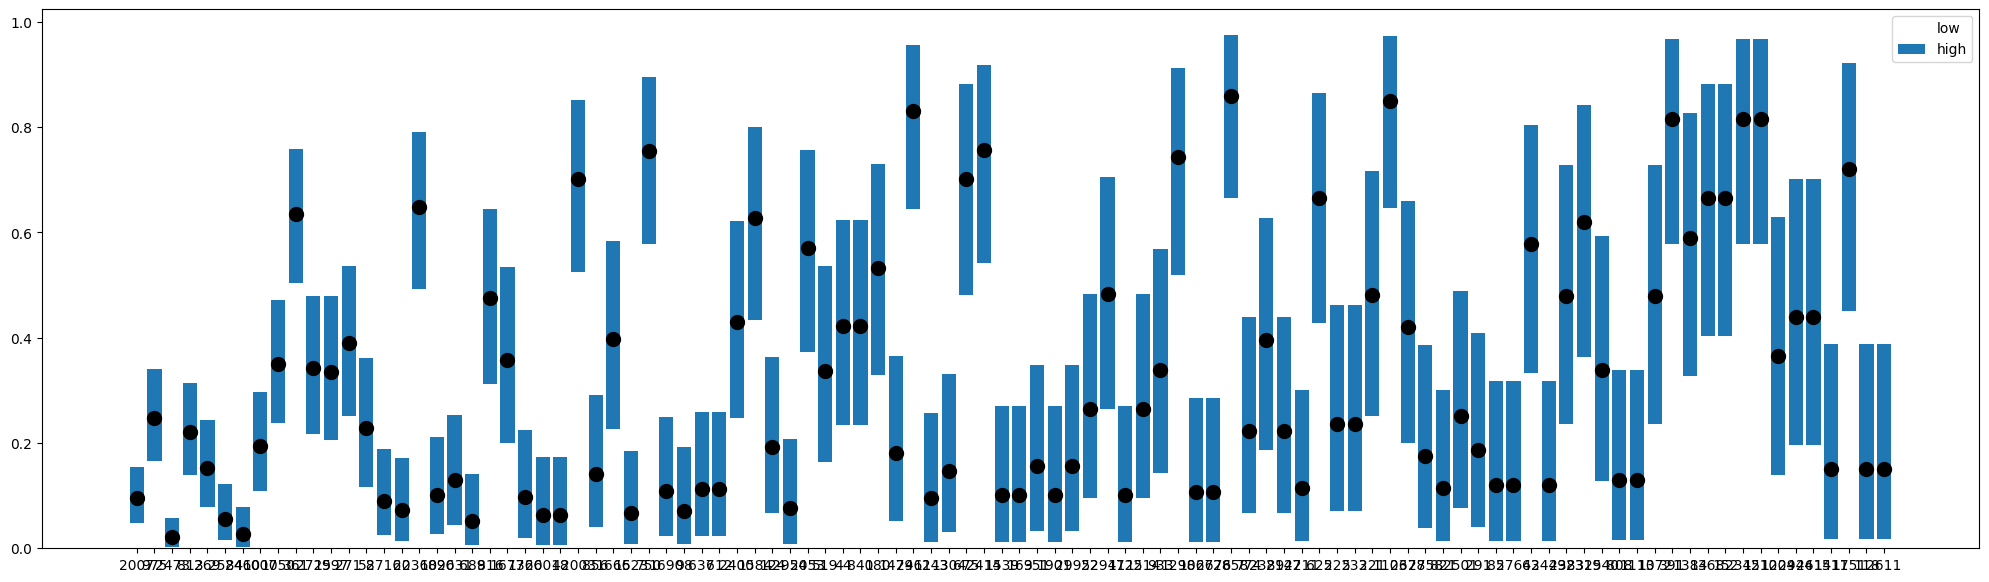

In [ ]:
# Number of customers to plot
n_cust = 100

# Plot
plt.figure(figsize=(25,7))
plt.scatter(df2.customer[:n_cust], df2.emp_bayes[:n_cust], color='black', s=100 )
plt.bar(df2.customer[:n_cust], df2.low[:n_cust], label='low', color='white', zorder=1 )
plt.bar(df2.customer[:n_cust], df2.high[:n_cust], label='high', zorder=0 )
plt.legend();

In [18]:
two_comp = df2.query('customer in ["808", "672"]')
two_comp

,customer,brick_mortar,ecomm,total_trx,ratio,emp_bayes,a1,b1,low,high
807,808,11,1,12,0.083333,0.129380,1.850939,12.455335,0.015230,0.338347
671,672,1,1,2,0.500000,0.429824,1.850939,2.455335,0.067127,0.851763


[distfit] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[distfit] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[distfit] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[distfit] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


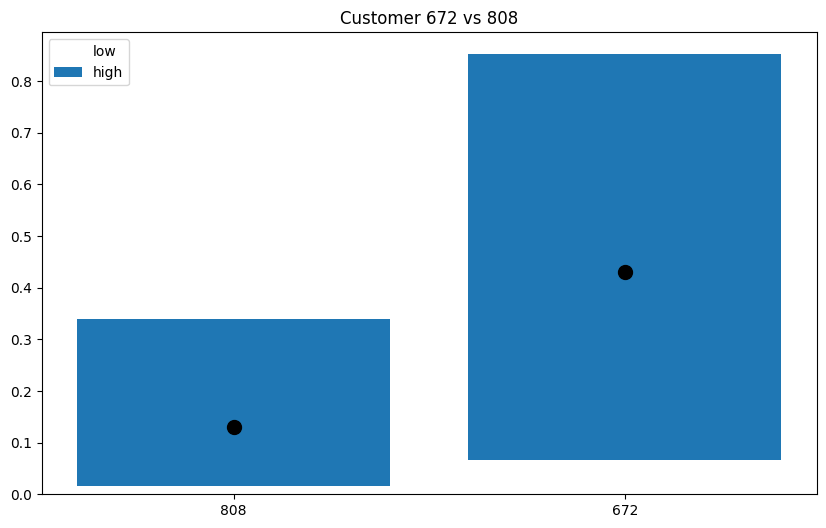

In [22]:
# Plot
plt.figure(figsize=(10,6))
plt.scatter(two_comp.customer, two_comp.emp_bayes, color='black', s=100 );
plt.bar(two_comp.customer, two_comp.low, label='low', color='white', zorder=1 );
plt.bar(two_comp.customer[:n_cust], two_comp.high[:n_cust], label='high', zorder=0 );
plt.title('Customer 672 vs 808')
plt.legend();

## What is the probability that 672 has higher ratio than 808 also P(ratio 672 > ratio 808).

In [24]:
# import scipy stats
import scipy.stats as scs
two_comp

,customer,brick_mortar,ecomm,total_trx,ratio,emp_bayes,a1,b1,low,high
807,808,11,1,12,0.083333,0.129380,1.850939,12.455335,0.015230,0.338347
671,672,1,1,2,0.500000,0.429824,1.850939,2.455335,0.067127,0.851763


In [38]:
# Collect customer's alpha and beta
a_672, b_672 = 1.850939, 2.455335

# Probability that customer 672 will have a higher rate than customer 808
prob = scs.beta.cdf(x= 0.429824, # cust. 808 ratio
             a = a_672, #alpha cust. 672
             b = b_672) # beta cust. 672

# 1 - prob because I want whatever is higher than 43%
print(f'Customer 672 has a {100*round(1-prob,1)}% probability to have a ratio over 43%')

Customer 672 has a 50.0% probability to have a ratio over 43%


In [ ]:
# View Conf Ints
df2.sort_values('ecomm', ascending=False).head()

,customer,brick_mortar,ecomm,total_trx,ratio,emp_bayes,a1,b1,low,high
360,361,18,33,51,0.647059,0.635027,33.850939,19.455335,0.502776,0.757678
2359,2360,12,24,36,0.666667,0.648743,24.850939,13.455335,0.493146,0.789628
974,975,68,22,90,0.244444,0.247556,22.850939,69.455335,0.165477,0.339990
1049,1050,39,21,60,0.350000,0.350702,21.850939,40.455335,0.238168,0.472317
749,750,5,19,24,0.791667,0.754609,19.850939,6.455335,0.577018,0.895657
